# Decomposing the Capacitated p-Median Problem
The capacitated p-median problem (CPMP) is a well studied problem. Here is a compact formulation of problem:

<img src="cpmp_lp.png" width="240">

There are many different approaches to solve the CPMP. As it has a structure, we can try to solve using a
Branch-Cut-and-Price approach. For that we want to use the Python interface of GCG. We will consider three
use-cases: (1) The Automatic Mode, (2) Exploring different Decompositions, and (3) Building a custom Decomposition.

To follow along with this tutorial interactively, please download the Jupyter notebook and all referenced resources
using the following link: [cpmp_complete.zip](cpmp_complete.zip)

## Reading in the Instance
One of the goals of this tutorial is to demonstrate how a problem modeled in Python can be handed to GCG. Please note that it is also possible to read in a problem in a standard format just like in PySCIPOpt using `Model.readProb()`.

In this example, we will be using the rather small CPMP instance [p550-01](instances/p550-01.cpmp). The file is in a custom file format. We provide the `reader_cpmp` module in the resources zip which reads in the instance and returns the input data.

Execute the following block in order to read in the example instance.

In [1]:
def read_instance(filename):
    """ Method to read the .cpmp instances
    :param filename: path to the instance to read

    Format of the .cpmp instances:
    
    [nlocations] [nclusters]
    [distance_1_1] ... [distance_1_nlocations]
    [distance_2_1] ... [distance_2_nlocations]
    ...            ... ... 
    [distance_nlocations_1] ... [distance_nlocations_nlocations]
    [demand_1] ... [demand_nlocations]
    [capacity_1] ... [capacity_nlocations]
    """
    def is_integer(s):
        try:
            int(s)
            return True
        except ValueError:
            return False

    def _parse_line(fp, ncols):
        line = fp.readline()
        sp = line.split()
        assert len(sp) == ncols
        assert all(is_integer(s) for s in sp)
        return dict(enumerate([int(s) for s in sp], start=1))

    with open(filename) as fp:
        line = fp.readline()
        
        # Reading the first line separately to get nlocations and nclusters
        nlocations = 0
        nclusters = 0
        sp = line.split()
        if len(sp) > 0 and sp[0].isnumeric():
            assert len(sp) == 2
            assert is_integer(sp[0]) and is_integer(sp[1])
            nlocations = int(sp[0])
            nclusters = int(sp[1])
        
        # Reading the distance matrix
        distances = {}
        
        for i in range(1, nlocations + 1):
            distances[i] = _parse_line(fp, nlocations)
            
        # Reading the demands
        demands = _parse_line(fp, nlocations)
          
        # Reading the capacities
        capacities = _parse_line(fp, nlocations)
        
        
    return nlocations, nclusters, distances, demands, capacities

n_locations, n_clusters, distances, demands, capacities = read_instance("instances/p550-01.cpmp")

## Setting up the Model
Now, we want to build the model based on the above formulation. Please note that this part is *not* specific to GCG but is *almost* identical to how one would build the same model with PySCIPOpt. In fact, the only difference is that we import and instanciate `GCGModel` instead of `Model`. In technical terms, `GCGModel` is a subclass of `Model` and, therefore, you can use all methods of `Model` to build your problem.

In order to recreate the model multiple times during this example, we create a method that will return the model. The method also returns the different constraints added to the model grouped by type. This will be important later in use-case 3.

In [2]:
from pygcgopt import GCGModel, quicksum

def build_model(n_locations, n_clusters, distances, demands, capacities):
    m = GCGModel()

    m.printVersion()
    m.redirectOutput()

    m.setMinimize()

    x = {}
    y = {}

    for j in range(1, n_locations + 1):
        y[j] = m.addVar(f"y_{j}", vtype="B")
        for i in range(1, n_locations + 1):
            x[i, j] = m.addVar(f"x_{i}_{j}", vtype="B", obj=distances[i][j])

    # Hold different constraint types
    conss_assignment = []
    conss_capacity = []
    cons_pmedian = None

    # Create the assignment constraints
    for i in range(1, n_locations + 1):
        conss_assignment.append(
            m.addCons(quicksum(x[i, j] for j in range(1, n_locations + 1)) == 1)
        )

    # Create the capacity constraints
    for j in range(1, n_locations + 1):
        conss_capacity.append(
            m.addCons(quicksum(demands[i] * x[i, j] for i in range(1, n_locations + 1)) <= capacities[j] * y[j])
        )

    # Create the p-median constraint
    cons_pmedian = m.addCons(quicksum(y[j] for j in range(1, n_locations + 1)) == n_clusters)

    return m, conss_assignment, conss_capacity, cons_pmedian

## Use-Case 1: The Automatic Mode
With the model built, we can now simply call the `optimize()` function and let GCG do its magic.

In [3]:
m, *conss = build_model(n_locations, n_clusters, distances, demands, capacities)
m.optimize()

GCG version 3.5.0 [GitHash: b54569ac6-dirty]
Copyright (C) 2010-2021 Operations Research, RWTH Aachen University
                        Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

SCIP version 8.0.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 6.0.0] [GitHash: 1af84b0617]
Copyright (C) 2002-2021 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)
presolving:
(round 1, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 100 upgd conss, 0 impls, 50 clqs
   (0.1s) probing: 51/2550 (2.0%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.1s) probing aborted: 50/50 successive totally useless probings
presolving (2 rounds: 2 fast, 2 medium, 2 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 2550 cliques
presolved problem has 2550 variables (2550 bin, 0 int, 0 impl, 0 cont)

## Use-Case 2: Exploring different Decompositions
Above, we have seen GCG in its fully automatic mode. If we want to dig deeper, we can inspect the different decompositions that GCG detects. For that, we recreate the model and manually execute `presolve()` and `detect()` for the model. At this stage it is possible to list and visualize the found decompositions.

In [4]:
m, *conss = build_model(n_locations, n_clusters, distances, demands, capacities)
m.presolve()
m.detect()

decomps = m.listDecompositions()

print("GCG found {} finnished decompositions.".format(len(decomps)))

GCG version 3.5.0 [GitHash: b54569ac6-dirty]
Copyright (C) 2010-2021 Operations Research, RWTH Aachen University
                        Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

SCIP version 8.0.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 6.0.0] [GitHash: 1af84b0617]
Copyright (C) 2002-2021 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)
presolving:
(round 1, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 100 upgd conss, 0 impls, 50 clqs
   (0.1s) probing: 51/2550 (2.0%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.1s) probing aborted: 50/50 successive totally useless probings
presolving (2 rounds: 2 fast, 2 medium, 2 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 2550 cliques
presolved problem has 2550 variables (2550 bin, 0 int, 0 impl, 0 cont)

### Inspecting Decompositions

The call to `listDecompositions()` returns a list of `PartialDecomposition` objects. We can print a decomposition using the Python `print()` function to get a summary or access different fields directly.

For a full overview of available methods, take a look at the online documentation for the `PartialDecomposition` class, or execute `help(d)` where `d` is a decomposition object.

In [5]:
print(decomps)

d = decomps[2]

print(
    f"Decomp scores: {d.classicScore=:.04f}, {d.borderAreaScore=:.04f}, {d.maxWhiteScore=:.04f}, {d.maxForWhiteScore=:.04f}"
)

[<PartialDecomposition: nBlocks=0, nMasterConss=101, nMasterVars=2550, nLinkingVars=0, maxForWhiteScore=0.0>, <PartialDecomposition: nBlocks=1, nMasterConss=0, nMasterVars=0, nLinkingVars=0, maxForWhiteScore=0.0>, <PartialDecomposition: nBlocks=50, nMasterConss=51, nMasterVars=0, nLinkingVars=0, maxForWhiteScore=0.48514851485148514>, <PartialDecomposition: nBlocks=51, nMasterConss=50, nMasterVars=0, nLinkingVars=0, maxForWhiteScore=0.49504950495049505>, <PartialDecomposition: nBlocks=1, nMasterConss=50, nMasterVars=0, nLinkingVars=0, maxForWhiteScore=0.0>, <PartialDecomposition: nBlocks=1, nMasterConss=100, nMasterVars=2500, nLinkingVars=0, maxForWhiteScore=0.009706853038245034>, <PartialDecomposition: nBlocks=1, nMasterConss=1, nMasterVars=0, nLinkingVars=0, maxForWhiteScore=0.0>, <PartialDecomposition: nBlocks=50, nMasterConss=51, nMasterVars=50, nLinkingVars=0, maxForWhiteScore=0.4853426519122501>, <PartialDecomposition: nBlocks=1, nMasterConss=1, nMasterVars=0, nLinkingVars=0, maxF

### Visualizing Decompositions
In addition, GCG can create graphical visualizations of decompositions. They can easily be displayed in a Jupyter nodebook like so:

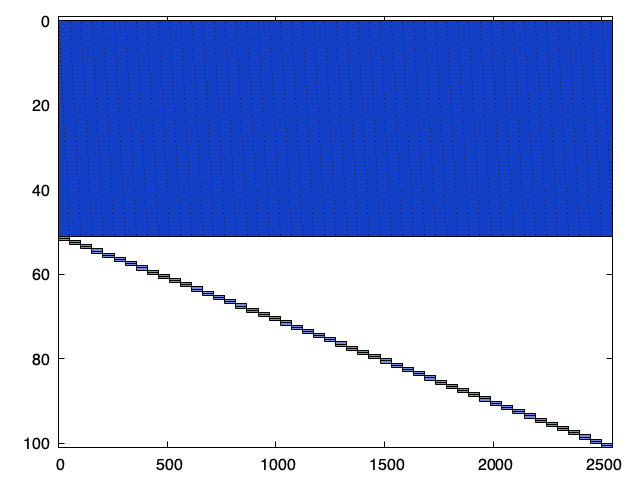

In [6]:
d

### Selecting Decompositions
After this investigation, we decide that we like this particular decomposition. The following code orders GCG to select our decomposition instead of an automatic one. Then, the optimization process is started.

In [7]:
d.isSelected = True

m.optimize()


A Dantzig-Wolfe reformulation is applied to solve the original problem.
Chosen structure has 50 blocks and 51 linking constraints.
This decomposition has a maxwhite score of 0.485149.
Matrix has 50 blocks, using 50 pricing problems.

  time | node  | left  |SLP iter|MLP iter|LP it/n| mem |mdpt |ovars|mvars|ocons|mcons|mcuts|  dualbound   | primalbound  |  deg   |  gap   
p  0.3s|     1 |     0 |      0 |      0 |     - |  34M|   0 |2550 |   0 | 101 |   0 |   0 | 0.000000e+00 | 2.711000e+03 |   --   |    Inf 
p  0.3s|     1 |     0 |      0 |      0 |     - |  33M|   0 |2550 |   0 | 101 |   0 |   0 | 0.000000e+00 | 1.785000e+03 |   --   |    Inf 
p  0.4s|     1 |     0 |      0 |      0 |     - |  33M|   0 |2550 |   0 | 101 |   0 |   0 | 0.000000e+00 | 1.102000e+03 |   --   |    Inf 
   0.4s|     1 |     0 |      0 |      0 |     - |  33M|   0 |2550 |   0 | 101 |   0 |   0 | 0.000000e+00 | 1.102000e+03 |   --   |    Inf 
  
     
 0.4s|     1 |     0 |      0 |      0 |     - |  34M|  

## Use-Case 3: Building a custom Decomposition
In the previous use-cases we run GCG with automatically detected decompositions. This is useful if we do not know the exact structure of a model but still want to exploit GCG's decomposition approach.

However, for our model we *do* know its structure. If you take another look at our `build_model()` method, you will notice that we store the created constraints in different variables based on their type. This is a typical approach when we want to specify a custom decomposition after building the model using the Python interface.

In the following code, we recreate our model and use the different constraint types fo select constraints for reformulation and constraints for the Dantzig-Wolfe master problem.

In [8]:
m, conss_assignment, conss_capacity, cons_pmedian = build_model(
    n_locations, n_clusters, distances, demands, capacities
)

conss_master = conss_assignment + [cons_pmedian]
conss_reform = conss_capacity

pd = m.createPartialDecomposition()
pd.fixConssToMaster(conss_master)

for block, c in enumerate(conss_reform):
    pd.fixConsToBlock(c, block)

m.addPreexistingPartialDecomposition(pd)

m.optimize()

GCG version 3.5.0 [GitHash: b54569ac6-dirty]
Copyright (C) 2010-2021 Operations Research, RWTH Aachen University
                        Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

SCIP version 8.0.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 6.0.0] [GitHash: 1af84b0617]
Copyright (C) 2002-2021 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)
 added complete decomp for original problem with 50 blocks and 51 masterconss, 0 linkingvars, 0 mastervars, and max white score of   0.485149 
there is an original decomposition and problem is not presolved yet -> disable presolving and start optimizing (rerun with presolve command before detect command for detecting in presolved problem)  
presolving:
presolving (0 rounds: 0 fast, 0 medium, 0 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 2550 v

## Summary

With that, we have seen the most important features to use GCG as a solver through the Python interface. In a different example, we will take a look at how GCG can be extended using Python code.